In [10]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import glob

from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
window_size = 100

def moving_average(x, window_size=window_size):
    return np.convolve(x, np.ones(window_size)/window_size, mode='valid')


def find_sign_change_step(steps, values):
    # Compute numerical derivative
    derivatives = np.diff(values)
    signs = np.sign(derivatives)

    # Look for sign changes
    for i in range(1, len(signs)):
        if signs[i] != 0 and signs[i] != signs[i - 1]:
            return steps[i + window_size - 1]  # Adjust index because of moving average window
    return None


def find_large_positive_derivative_step(steps, values, threshold=0.008):
    derivatives = np.diff(values)
    for i, d in enumerate(derivatives):
        if d > threshold:
            return float(steps[i + 1])
    return None

In [12]:

ratios = {}
ratios['fp6_e2m3_fp6_e3m2'] = [9.73842, 16.23425, 62.08117, 83.29887, 113.2144, 156.01372]
ratios['fp6_e3m2_fp6_e3m2'] = [42.36739, 62.40892, 93.80541, 144.13805]
# ratios['fp8_e4m3_fp8_e4m3'] = [42.36739, 62.40892, 93.80541, ]

In [13]:
choice = 'fp6_e2m3_fp6_e3m2'
csv_files = glob.glob(f"data/training_loss/{choice}/*.csv")  

[5.05078125 4.3046875  4.1640625  ... 2.33984375 2.38574219 2.33984375]
smoothed [2.89368164 2.86678711 2.84720703 ... 2.30689453 2.30776367 2.30822266]
[5.43164062 4.37695312 4.21484375 ... 2.59082031 2.59082031 2.59765625]
smoothed [2.98121094 2.95132813 2.93177734 ... 2.60586914 2.60571289 2.60581055]
[5.0546875  4.34179688 4.22851562 ... 5.09375    5.01953125 5.0625    ]
smoothed [3.01078125 2.98579102 2.96768555 ... 4.61262695 4.61930664 4.62661133]
[5.08007812 4.3671875  4.25       ... 5.9609375  5.96875    5.984375  ]
smoothed [3.04848633 3.02356445 3.005625   ... 5.98695312 5.98705078 5.98726563]
[4.88476562 4.36523438 4.26171875 ... 6.23632812 4.28515625 4.10253906]
smoothed [3.02392578 3.0006543  2.98280273 ... 5.04900391 5.03935547 5.02352539]
[4.58789062 4.37304688 4.28125    ... 6.08398438 6.11132812 6.140625  ]
smoothed [3.09355469 3.07422852 3.05693359 ... 5.22244141 5.22138672 5.22121094]


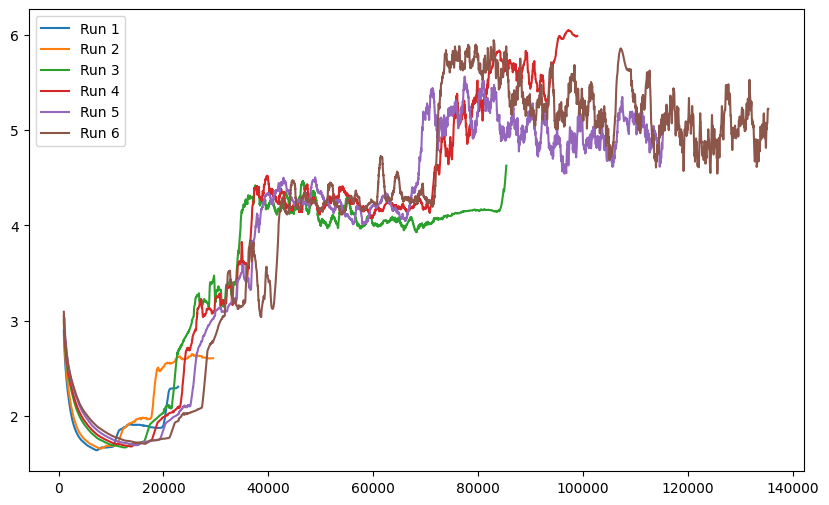

In [14]:
results = []

plt.figure(figsize=(10, 6))
for idx, file in enumerate(sorted(csv_files)):
    df = pd.read_csv(file)

    step_col = "Step"
    loss_col = [col for col in df.columns if "CrossEntropyLoss" in col and "__" not in col][0]

    steps = df[step_col].astype(float).values
    losses = df[loss_col].astype(float).values
    print(losses)
    smoothed = moving_average(losses, window_size)
    print('smoothed', smoothed)
    smoothed_steps = steps[window_size - 1:]  # Align with moving average

    sign_change_step = find_large_positive_derivative_step(smoothed_steps, smoothed)
    results.append(sign_change_step)

    label = f"Run {idx + 1}"
    plt.plot(smoothed_steps, smoothed, label=label)

plt.legend()

In [15]:
results

[None, 14660.0, 20080.0, 20840.0, 22940.0, 22910.0]

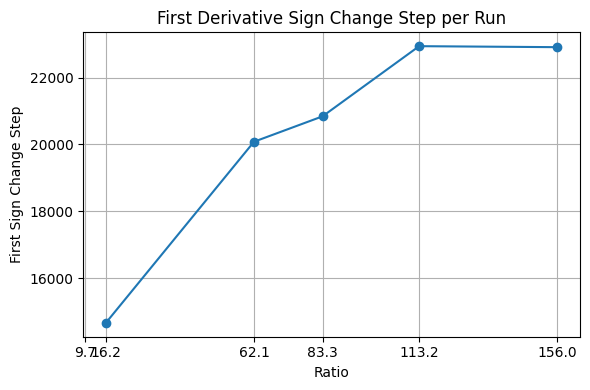

In [16]:

plt.figure(figsize=(6, 4))
plt.plot(ratios[choice], results, marker='o')
plt.xticks(ratios[choice])
plt.xlabel("Ratio")
plt.ylabel("First Sign Change Step")
plt.title("First Derivative Sign Change Step per Run")
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
choice = 'fp6_e2m3_fp6_e3m2'
csv_files = glob.glob(f"data/grad_norm/{choice}/*.csv")  

In [34]:

def moving_average(series, window=1000):
    return series.rolling(window=window, min_periods=1).mean()

def numerical_derivative(series):
    return series.diff().fillna(0)

# where derivative changes sign, ignoring first X steps
def find_sign_changes(series, ignore_initial=100):
    derivative_sign = np.sign(series)
    sign_changes = derivative_sign.diff().fillna(0).ne(0)
    sign_change_indices = sign_changes[ignore_initial:].index[sign_changes[ignore_initial:]].tolist()
    return sign_change_indices

/tmp/ipykernel_1721670/2258392863.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


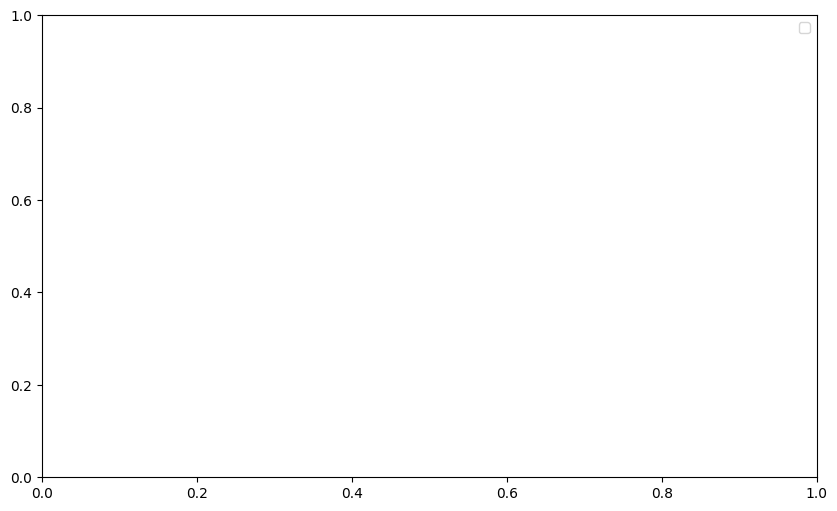

In [35]:
results = []

plt.figure(figsize=(10, 6))
for idx, file in enumerate(sorted(csv_files)):
    df = pd.read_csv(file)

    step_col = "Step"
    # loss_col = [col for col in df.columns if "CrossEntropyLoss" in col and "__" not in col][0]

    # steps = df[step_col].astype(float).values
    # losses = df[loss_col].astype(float).values
    smoothed_grad_norm = moving_average(df['fp6_e2m3_fp6_e3m2 - optim/total_grad_norm'])
    # smoothed = moving_average(losses, window_size)
    grad_norm_derivative = numerical_derivative(smoothed_grad_norm)
    sign_changes = find_sign_changes(grad_norm_derivative)

    plt.plot(smoothed_grad_norm, label=label)

    results.append(sign_changes[0])

    label = f"Run {idx + 1}"
    # plt.plot(sign_changes, smoothed, label=label)

plt.legend()

In [36]:
results

[197, 223, 108, 163, 181, 103]

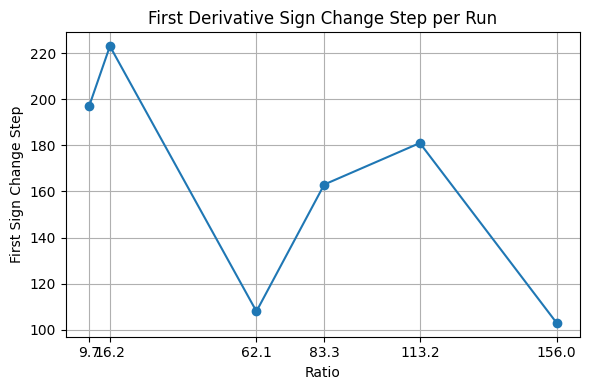

In [37]:
plt.figure(figsize=(6, 4))
plt.plot(ratios[choice], results, marker='o')
plt.xticks(ratios[choice])
plt.xlabel("Ratio")
plt.ylabel("First Sign Change Step")
plt.title("First Derivative Sign Change Step per Run")
plt.grid(True)
plt.tight_layout()
plt.show()